In [11]:
# Inicializar sesión de spark

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("Human Activity Recognition")
    .config("spark.driver.memory", "1g")
    .master("local[4]")
    .getOrCreate()
)

In [9]:
# Cargar los datos desde txt (csv)

from load import load_accelerometer_data, load_demographic_data

ad = load_accelerometer_data(spark, '/data/WISDM_at_v2.0_raw.txt')
demo = load_demographic_data(spark, '/data/WISDM_at_v2.0_demographics.txt')

ModuleNotFoundError: No module named 'load'

In [21]:
# Cantidad de rows y schemas

print("Accelerometer data count: ", ad.count())
print("Accelerometer partitions: ", ad.rdd.getNumPartitions())
ad.printSchema()

print("Demographics data count: ", demo.count())
print("Demographics partitions: ", demo.rdd.getNumPartitions())
demo.printSchema()

Accelerometer data count:  3005411
Accelerometer partitions:  4
root
 |-- userId: integer (nullable = true)
 |-- action: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)

Demographics data count:  563
Demographics partitions:  1
root
 |-- userId: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- leg_injury: integer (nullable = true)



In [22]:
# Análisis de nulls. Cuantos nulls hay por cada columna?

from pyspark.sql.functions import count, when, col, isnan, mean

def print_null_columns(df):
    df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

print ("Null values in each column of Accelerometer data: ")
print_null_columns(ad)

print ("Null values in each column of Demographics data: ")
print_null_columns(demo)

Null values in each column of Accelerometer data: 


+------+------+---------+-----+-----+-----+
|userId|action|timestamp|    x|    y|    z|
+------+------+---------+-----+-----+-----+
|     0| 24646|    24646|24646|24646|24646|
+------+------+---------+-----+-----+-----+

Null values in each column of Demographics data: 
+------+------+---+---+------+----------+
|userId|height|sex|age|weight|leg_injury|
+------+------+---+---+------+----------+
|     0|    25| 15| 17|    52|        20|
+------+------+---+---+------+----------+



In [23]:
# Que acciones hay presentes en todo el dataset?

print("Actions present in the Accelerometer data: ", 
" , ".join([a[0] for a in ad.filter(col("action").isNotNull()).select("action").distinct().collect()]))

Actions present in the Accelerometer data:  Sitting , Walking , Standing , Stairs , LyingDown , Jogging


In [24]:
# Cantidad de rows por acción

print("Number of samples per action: ")
actions_count = dict([(a[0], a[1]) for a in ad.groupBy('action').count().orderBy('count', ascending=False).collect()])
for k,v in actions_count.items():
    print(k, v)

Number of samples per action: 


Walking 1255923
Sitting 663706
Jogging 438871
Standing 288873
LyingDown 275967
Stairs 57425
None 24646


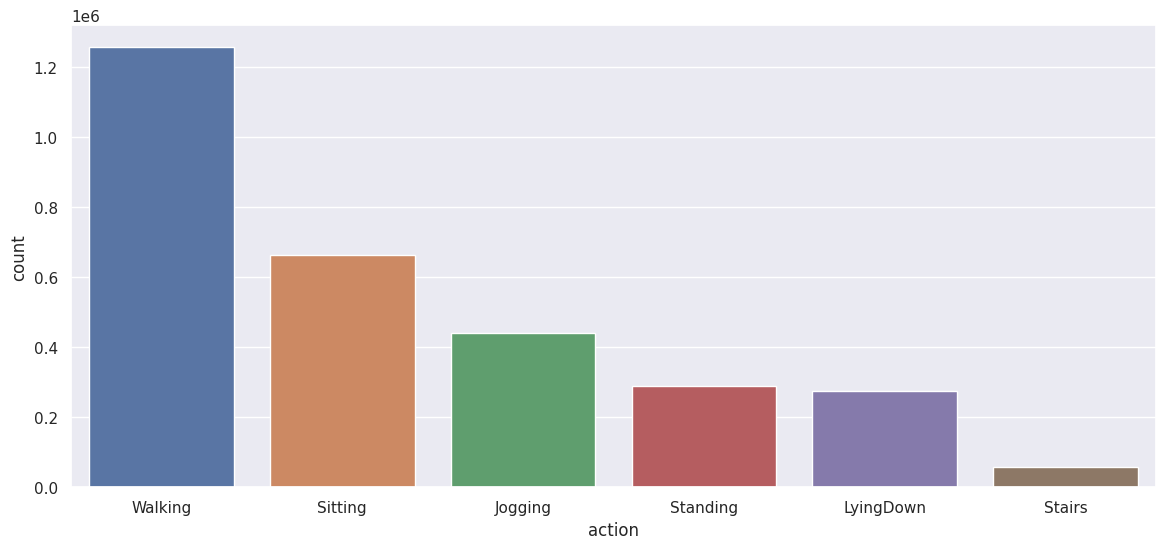

In [25]:
# Grafico la cantidad de rows por acción en un barplot

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
 
plt.figure(figsize=(14,6))
sns.set_theme()
sns.barplot(x = 'action',
            y = 'count',
            data = pd.DataFrame({'action': actions_count.keys(), 'count': actions_count.values()}))

plt.show()

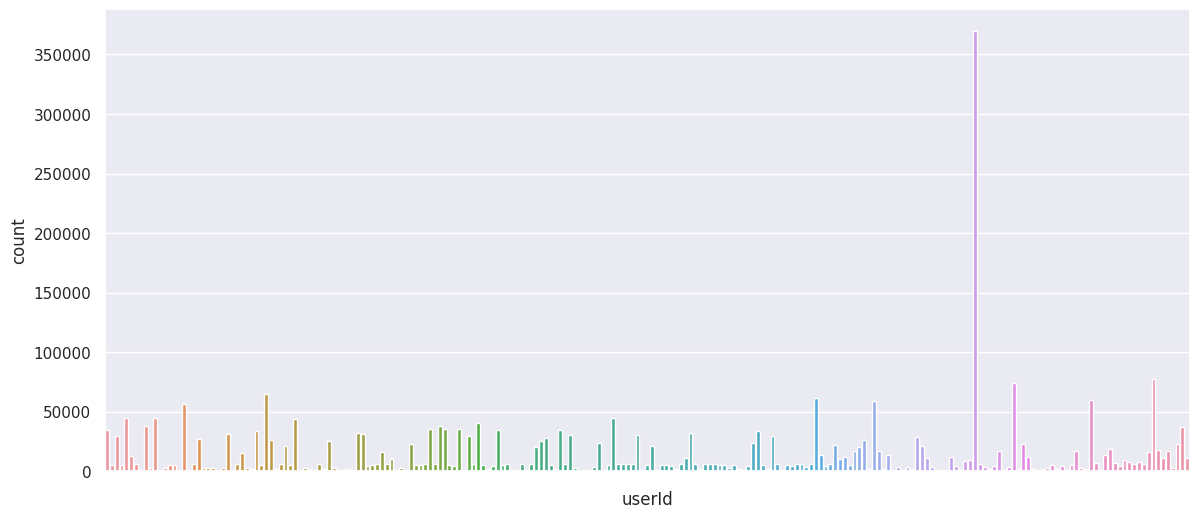

In [26]:
# Cantidad de eventos registrados por usuario
user_count = ad.groupBy('userId').count().orderBy('count', ascending=False).toPandas()

plt.figure(figsize=(14,6))
sns.set_theme()
p = sns.barplot(x = 'userId',
            y = 'count',
            data = user_count)
p.set(xticklabels=[])

plt.show()

In [28]:
# Según la documentación del dataset, las medidas deberían encontrarse entre -20 y 20.
# Veo si hay rows con valores mayores

from pyspark.sql.functions import abs, max, min, lit

rows_outside_bounds = ad.filter((abs(col('x')) > lit(20)) | (abs(col('y')) > lit(20)) | (abs(col('z')) > lit(20))).count()

print("Rows with measures outside boundaries (-20, +20): ", rows_outside_bounds)

print("Maximum absolute values of each axis: ")
ad.select(max(abs(ad.x)).alias('max_abs_x'), max(abs(ad.y)).alias('max_abs_y'), max(abs(ad.z)).alias('max_abs_z')).show()

Rows with measures outside boundaries (-20, +20):  10226
Maximum absolute values of each axis: 


+-------------+------------+------------+
|    max_abs_x|   max_abs_y|   max_abs_z|
+-------------+------------+------------+
|1.44413671E17|4.0947096E11|5.9150805E20|
+-------------+------------+------------+



#### Analizaremos un usuario particular para ver como lucen las distintas acciones en cada sensor:

In [29]:
# Primero busco a aquel usuario con mayor cantidad de acciones y eventos, que voy a utilizar como ejemplo

from pyspark.sql.functions import countDistinct, col, count

user = ad.filter(col('action').isNotNull())\
    .groupby('userId')\
    .agg(countDistinct('action').alias('action'), count('timestamp').alias('timestamp'))\
    .orderBy(col('action').desc(), col('timestamp').desc())\
    .limit(1)\
    .collect()

print("User with most actions and events:", user)

userId = user[0][0]

User with most actions and events: [Row(userId=194, action=6, timestamp=34978)]


In [31]:
# Filtro eventos del usuario 194
user_events = ad.filter((col("userId") == lit(userId)) & (col("action").isNotNull()))
user_events.show()

+------+--------+-------------+-----------+---------+----------+
|userId|  action|    timestamp|          x|        y|         z|
+------+--------+-------------+-----------+---------+----------+
|   194|Standing|1370367549273|-0.38245934|10.473502|-1.6769371|
|   194|Standing|1370367549324|-0.38245934|10.473502|-1.7259704|
|   194|Standing|1370367549374|-0.38245934|10.473502|-1.7651969|
|   194|Standing|1370367549479|-0.38245934|10.473502|-1.8044236|
|   194|Standing|1370367549529|-0.38245934|10.522535|-1.8044236|
|   194|Standing|1370367549589|-0.38245934|10.522535|-1.7553903|
|   194|Standing|1370367549639|-0.38245934|10.522535| -1.706357|
|   194|Standing|1370367549689|-0.42168593|10.522535| -1.706357|
|   194|Standing|1370367549739|-0.42168593|10.473502|-1.8534569|
|   194|Standing|1370367549807|-0.42168593|10.473502|-1.7946169|
|   194|Standing|1370367549857|-0.46091253|10.473502|-1.7946169|
|   194|Standing|1370367550198|-0.40207264|10.473502|-1.7946169|
|   194|Standing|13703675

In [32]:
# Recordamos filtrar valores fuera de +20, -20. Si el valor es mayor a 20 ponemos 20, si es menor a -20, ponemos -20
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

limit = 20

cap_value = udf(lambda x: limit if x > limit else -limit if x < -limit else x, DoubleType())

for c in ['x', 'y', 'z']:
    user_events = user_events.withColumn(c, cap_value(c))

print("Max absolute value of x,y,z sensors after filtering: ")
user_events.select(max(abs(user_events.x)).alias('max_abs_x'), max(abs(user_events.y)).alias('max_abs_y'), max(abs(user_events.z)).alias('max_abs_z')).show()

Max absolute value of x,y,z sensors after filtering: 
23/01/22 18:02:58 ERROR Executor: Exception in task 1.0 in stage 45.0 (TID 54)
java.io.IOException: Cannot run program "= /usr/bin/python3.9": error=2, No such file or directory
	at java.base/java.lang.ProcessBuilder.start(Unknown Source)
	at java.base/java.lang.ProcessBuilder.start(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:216)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:134)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at

Py4JJavaError: An error occurred while calling o311.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 45.0 failed 1 times, most recent failure: Lost task 2.0 in stage 45.0 (TID 55) (74da29399599 executor driver): java.io.IOException: Cannot run program "= /usr/bin/python3.9": error=2, No such file or directory
	at java.base/java.lang.ProcessBuilder.start(Unknown Source)
	at java.base/java.lang.ProcessBuilder.start(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:216)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:134)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: java.io.IOException: error=2, No such file or directory
	at java.base/java.lang.ProcessImpl.forkAndExec(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(Unknown Source)
	at java.base/java.lang.ProcessImpl.start(Unknown Source)
	... 30 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.IOException: Cannot run program "= /usr/bin/python3.9": error=2, No such file or directory
	at java.base/java.lang.ProcessBuilder.start(Unknown Source)
	at java.base/java.lang.ProcessBuilder.start(Unknown Source)
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:216)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:134)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:107)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:164)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:81)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:131)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:855)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:855)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:365)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:329)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: java.io.IOException: error=2, No such file or directory
	at java.base/java.lang.ProcessImpl.forkAndExec(Native Method)
	at java.base/java.lang.ProcessImpl.<init>(Unknown Source)
	at java.base/java.lang.ProcessImpl.start(Unknown Source)
	... 30 more


In [67]:
# Necesito agrupar eventos concretos como registros consecutivos de la misma accion

from pyspark.sql.functions import col, lag, sum
from pyspark.sql import Window

w1 = Window.orderBy('timestamp')

user_events = user_events\
    .withColumn("indicator", (col("action") != lag("action").over(w1)).cast("int"))\
    .fillna(0, subset=[ "indicator"])\
    .withColumn("event", sum(col("indicator")).over(w1.rangeBetween(Window.unboundedPreceding, 0)))\
    .drop(col("indicator"))

#### Grafico sensores x,y,z para cada tipo de acción:

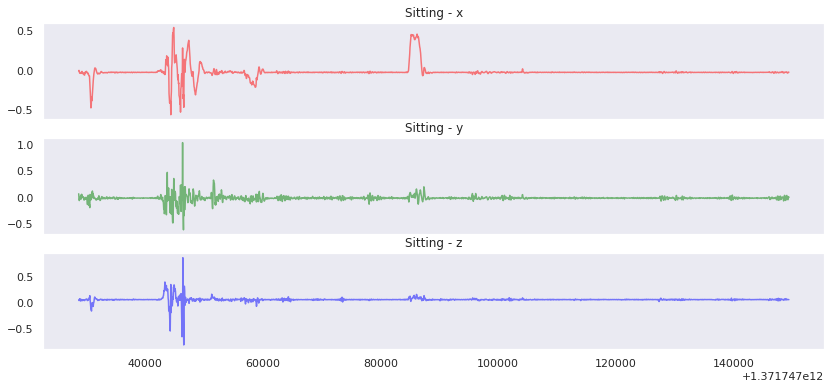

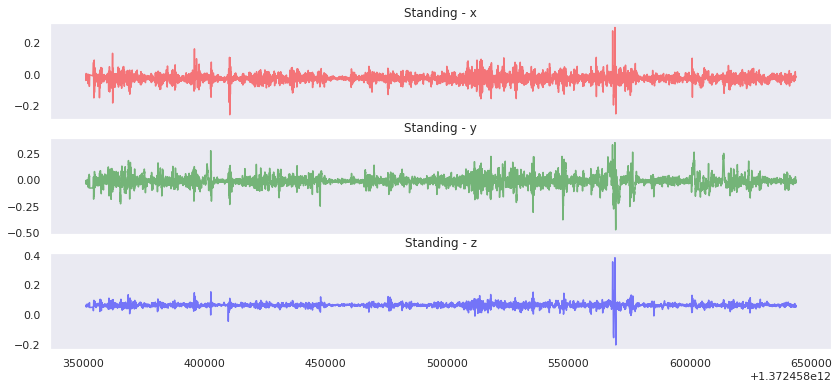

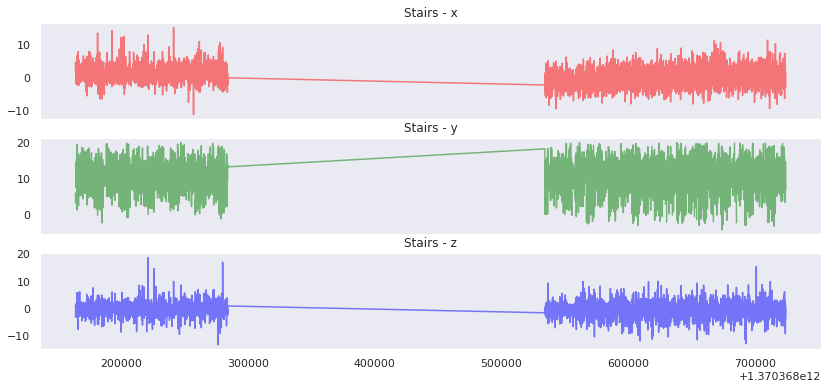

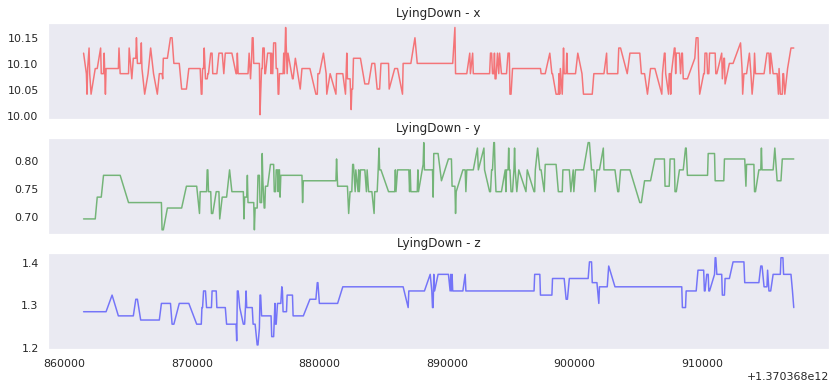

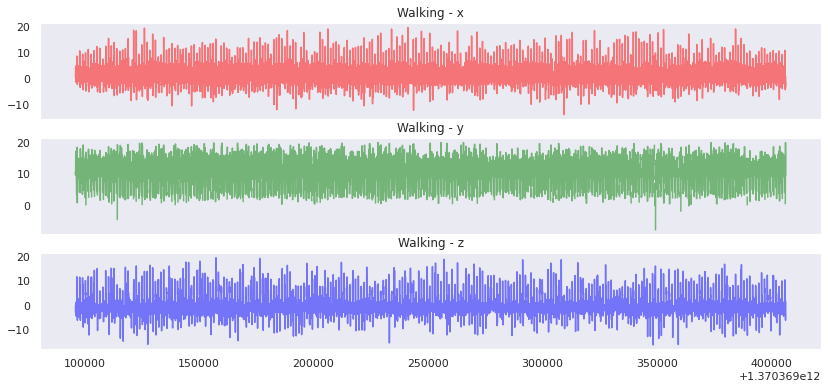

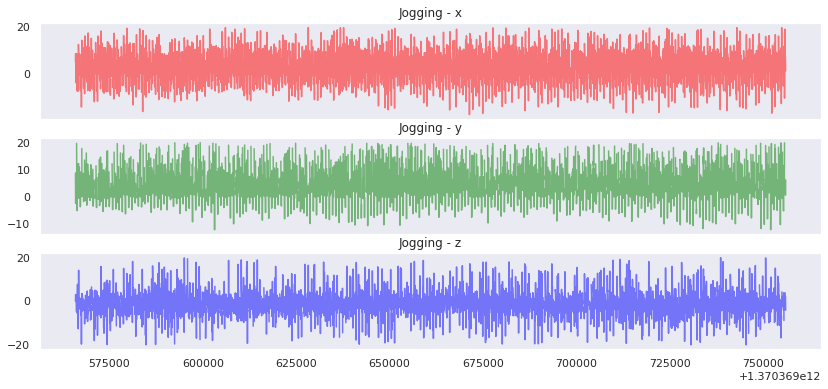

In [72]:
# La idea de ésta funcion plot_xyz fue tomada de: https://www.kaggle.com/code/docxian/human-activity-recognition-visual-exploration

def plot_xyz(df, userId, action):   
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14,6), sharex=True)
    
    ax1.plot(df['timestamp'], df['x'], color='red', alpha=0.5)
    ax1.set_title(action + ' - x')
    ax1.grid()
    
    ax2.plot(df['timestamp'], df['y'], color='green', alpha=0.5)
    ax2.set_title(action + ' - y')
    ax2.grid()

    ax3.plot(df['timestamp'], df['z'], color='blue', alpha=0.5)
    ax3.set_title(action + ' - z')
    ax3.grid()
    
    plt.show()


for action in [a[0] for a in user_events.select("action").distinct().collect()]:
    # Tomo el evento con mas rows consecutivas de cada accion
    event = user_events.filter(col("action") == lit(action))\
    .groupby('event')\
    .count()\
    .orderBy(col('count').desc())\
    .limit(1)\
    .collect()[0][0]
   
    # Ploteo solo un evento por cada acción
    df = user_events.filter((col("action") == lit(action)) & (col("event") == lit(event))).toPandas()
    plot_xyz(df, userId, action)

#### Analizamos el matcheo entre usuarios de data demográfica y usuarios con lectura de sensores:

In [79]:
# Join both tables by user id. Outer to check later if there's missing data for the join.
ad_2 = ad.dropna(how="any")
demo_2 = demo.dropna(how="any")
joined = ad_2.join(demo_2, ad_2.userId == demo_2.userId, 'fullouter').drop(demo_2.userId)

# Check if any join failed
print_null_columns(joined)

+------+------+---------+---+---+---+-------+-------+-------+-------+----------+
|userId|action|timestamp|  x|  y|  z| height|    sex|    age| weight|leg_injury|
+------+------+---------+---+---+---+-------+-------+-------+-------+----------+
|   449|   449|      449|449|449|449|2149304|2149304|2149304|2149304|   2149304|
+------+------+---------+---+---+---+-------+-------+-------+-------+----------+



In [80]:
print("Count of accelerometer data: ", ad_2.count())
print("Count of demographic data: ", demo_2.count())
print("Count of inner join: ", ad_2.join(demo_2, ad_2.userId == demo_2.userId, "inner").count())

Count of accelerometer data:  2980765
Count of demographic data:  491
Count of inner join:  1741731


Hay muchas rows de accelerometer data que no matchean con la data demográfica, y por ende decido no utilizar ésta última.

#### Análisis para división en training/testing. Cuál es el punto de corte óptimo?

In [13]:
# Primero vemos cual es el min vs max user Id
from pyspark.sql.functions import max,min,col

min_max_userId = ad.select(min(col("userId")).alias("min_userId"), max(col("userId")).alias("max_userId")).collect()
print("Min:", min_max_userId[0][0], "Max:", min_max_userId[0][1])

Min: 194 Max: 1802


In [23]:
# Ahora exploramos distintos puntos de corte y que proporción de rows deja cada uno
min_uid = min_max_userId[0][0]
max_uid = min_max_userId[0][1]
range_uid = (max_uid - min_uid)
start = int(range_uid * 0.7) + min_uid
end = int(range_uid * 0.9) + min_uid
step = (end - start) // 10

for i in range(start, end, step):
    train_count = ad.filter(col("userId") <= i).count()
    test_count = ad.filter(col("userId") > i).count()
    total_count = train_count + test_count
    print("User Id thershold:", i, "Training proportion: ", round(train_count / total_count, 2), "Testing proportion: ", round(test_count / total_count, 2))


User Id thershold: 1319 Training proportion:  0.67 Testing proportion:  0.33
User Id thershold: 1351 Training proportion:  0.67 Testing proportion:  0.33
User Id thershold: 1383 Training proportion:  0.67 Testing proportion:  0.33
User Id thershold: 1415 Training proportion:  0.67 Testing proportion:  0.33
User Id thershold: 1447 Training proportion:  0.67 Testing proportion:  0.33
User Id thershold: 1479 Training proportion:  0.68 Testing proportion:  0.32
User Id thershold: 1511 Training proportion:  0.68 Testing proportion:  0.32
User Id thershold: 1543 Training proportion:  0.69 Testing proportion:  0.31
User Id thershold: 1575 Training proportion:  0.69 Testing proportion:  0.31
User Id thershold: 1607 Training proportion:  0.81 Testing proportion:  0.19
User Id thershold: 1639 Training proportion:  0.82 Testing proportion:  0.18


Elijo entonces 1607 como user threshold para que me quede 80% de training y 20% de testing